In [1]:
import ezc3d
walk_1 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Walk-001/pose_filt_0.c3d")
walk_2 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Walk-002/pose_filt_0.c3d")
hop_single = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/HopSingle-001/pose_filt_0.c3d")
cmj_1 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/CMJ-001/pose_filt_0.c3d")
cmj_2 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/CMJ-002/pose_filt_0.c3d")
cmj_3 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/CMJ-003/pose_filt_0.c3d")
triple_hop_1 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/HopTriple-001/pose_filt_0.c3d")
triple_hop_2 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/HopTriple-002/pose_filt_0.c3d")
pistol_right = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Pistol-001/pose_filt_0.c3d")
pistol_left = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Pistol-002/pose_filt_0.c3d")
squat_1 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Squat001/pose_filt_0.c3d")
squat_2 = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Squat001-000/pose_filt_0.c3d")
jog = ezc3d.c3d("/Users/harrietdray/Biodynamics/Harriet_c3d/Jog-001/pose_filt_0.c3d")


import matplotlib.pyplot as plt

labels = pistol_left['parameters']['POINT']['LABELS']['value'] # List of angle names



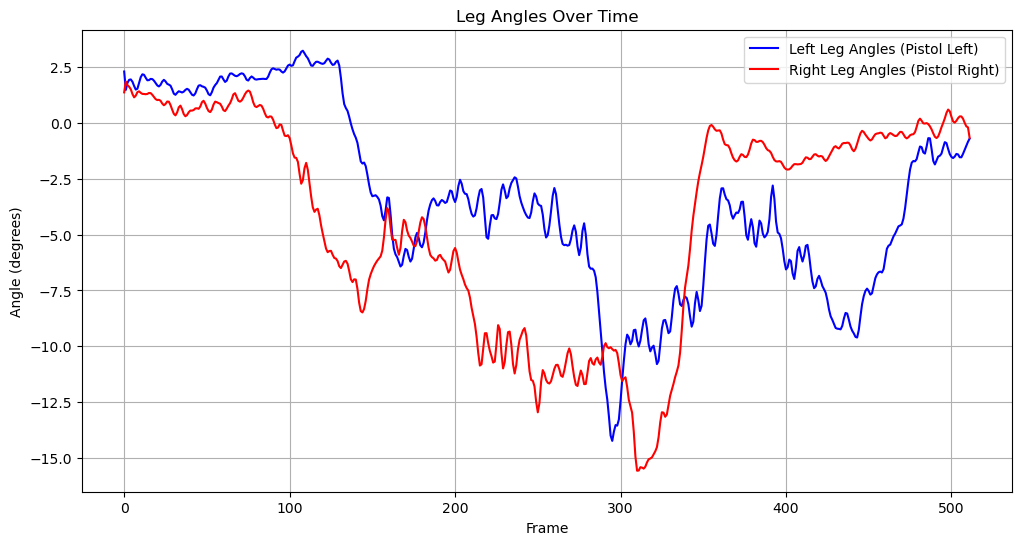

In [15]:
# Extracting angle data from the c3d file
import numpy as np

angle_data_trials = [pistol_left['data']['points'], pistol_right['data']['points']]

angle_indices = {
    'left_knee': labels.index('LeftKneeAngles_Theia'),
    'right_knee': labels.index('RightKneeAngles_Theia'),
    'left_hip': labels.index('LeftHipAngles_Theia'),
    'right_hip': labels.index('RightHipAngles_Theia'),
    'left_fp': labels.index('LeftFootProgressionAngles_Theia'),
    'right_fp': labels.index('RightFootProgressionAngles_Theia')
}

angles = {key: {'Saggital': [], 'Frontal': [], 'Transverse': []} for key in angle_indices.keys()}


min_frames = min(data.shape[2] for data in angle_data_trials)
for key, idx in angle_indices.items():
    is_left = 'left' in key
    
    angles[key]['Saggital'] = [
        data[0, idx, :min_frames] if is_left else data[0, idx, :min_frames]
        for data in angle_data_trials
    ]
    angles[key]['Frontal'] = [
        data[1, idx, :min_frames] if is_left else data[1, idx, :min_frames]
        for data in angle_data_trials
    ]
    angles[key]['Transverse'] = [
        data[2, idx, :min_frames] for data in angle_data_trials
    ]

# Compute angles for left leg on pistol_left and right leg on pistol_right
left_leg_angles = pistol_left['data']['points'][1, angle_indices['left_knee'], :min_frames]

right_leg_angles = pistol_right['data']['points'][1, angle_indices['right_knee'], :min_frames]

angles['left_knee']['Frontal'].append(left_leg_angles)
angles['right_knee']['Frontal'].append(right_leg_angles)
# Compute angles for both left and right legs on both pistols
left_leg_angles_pistol_left = -pistol_left['data']['points'][1, angle_indices['left_knee'], :min_frames]
right_leg_angles_pistol_left = pistol_left['data']['points'][1, angle_indices['right_knee'], :min_frames]

left_leg_angles_pistol_right = -pistol_right['data']['points'][1, angle_indices['left_knee'], :min_frames]
right_leg_angles_pistol_right = pistol_right['data']['points'][1, angle_indices['right_knee'], :min_frames]

# Append to angles dictionary
angles['left_knee']['Frontal'].append(left_leg_angles_pistol_left)
angles['right_knee']['Frontal'].append(right_leg_angles_pistol_left)
angles['left_knee']['Frontal'].append(left_leg_angles_pistol_right)
angles['right_knee']['Frontal'].append(right_leg_angles_pistol_right)

#average_of_trials = np.mean(angles['left_knee']['Saggital'], axis=0)

# Plotting all trials on the same graph
# Plotting left leg angles for pistol_left and right leg angles for pistol_right
plt.figure(figsize=(12, 6))
plt.plot(left_leg_angles_pistol_left, label='Left Leg Angles (Pistol Left)', color='blue')
plt.plot(right_leg_angles_pistol_right, label='Right Leg Angles (Pistol Right)', color='red')

plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Leg Angles Over Time')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
def align_jumps_by_max_flexion(angle_trials):
    aligned_trials = []
    peak_indices = []
    
    for trial in angle_trials:
        # Find maximum flexion (highest angle value)
        peak_idx = np.argmax(trial) 
        peak_indices.append(peak_idx)
        aligned_trials.append(trial)
    
    return aligned_trials, peak_indices

def create_aligned_average(trials, peak_indices, window_before=50, window_after=100):
    aligned_segments = []
    
    for trial, peak_idx in zip(trials, peak_indices):
        # Define window around peak
        start_idx = max(0, peak_idx - window_before)
        end_idx = min(len(trial), peak_idx + window_after)
        
        # Extract segment and pad if necessary
        segment = trial[start_idx:end_idx]
        
        # Pad to consistent length if needed
        target_length = window_before + window_after
        if len(segment) < target_length:
            # Pad with edge values
            pad_before = window_before - (peak_idx - start_idx)
            pad_after = target_length - len(segment) - pad_before
            segment = np.pad(segment, (pad_before, pad_after), mode='edge')
        
        aligned_segments.append(segment[:target_length])
    
    # Calculate average
    aligned_average = np.mean(aligned_segments, axis=0)
    
    return aligned_segments, aligned_average

# Apply to your left knee data - corrected version
left_knee_trials = angles['left_knee']['Saggital']
aligned_trials, peak_indices = align_jumps_by_max_flexion(left_knee_trials)  # Using corrected function
aligned_segments, aligned_average = create_aligned_average(left_knee_trials, peak_indices)

# Plot results
plt.figure(figsize=(12, 6))

# Plot individual aligned trials
for i, segment in enumerate(aligned_segments):
    plt.plot(range(-50, 100), segment, alpha=0.7, label=f'Trial {i+1}')

# Plot aligned average
plt.plot(range(-50, 100), aligned_average, 'k-', linewidth=3, label='Aligned Average')

plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Maximum Flexion')  # Updated label
plt.xlabel('Frames relative to maximum flexion')  # Updated label
plt.ylabel('Knee Flexion Angle (degrees)')
plt.title('Aligned Knee Flexion - Centered on Maximum Flexion')  # Updated title
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print maximum flexion values
print("Maximum flexion angles:")
for i, (trial, peak_idx) in enumerate(zip(left_knee_trials, peak_indices)):
    print(f"Trial {i+1}: {trial[peak_idx]:.1f}° at frame {peak_idx}")
    
print(f"\nAverage maximum flexion: {np.mean([trial[peak_idx] for trial, peak_idx in zip(left_knee_trials, peak_indices)]):.1f}°")

In [ ]:
# Apply same alignment to other joints
joints_to_analyze = ['right_knee', 'left_hip', 'right_hip']

for joint in joints_to_analyze:
    joint_trials = angles[joint]['Saggital']
    aligned_trials, peak_indices = align_jumps_by_max_flexion(joint_trials)
    aligned_segments, aligned_average = create_aligned_average(joint_trials, peak_indices)
    
    # Plot each joint
    plt.figure(figsize=(10, 6))
    for i, segment in enumerate(aligned_segments):
        plt.plot(range(-50, 100), segment, alpha=0.7, label=f'Trial {i+1}')
    plt.plot(range(-50, 100), aligned_average, 'k-', linewidth=3, label='Average')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.title(f'{joint.title()} Flexion - Aligned')
    plt.xlabel('Frames relative to peak flexion')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.show()